# Text Sentiment classificattion (feat.klue.korbert)

In [ ]:
!python --version

Python 3.10.12


### 나눔고딕 글꼴 사용 시 설치

> 워드 클라우드 사용을 위해 코랩 환경에 한글 폰트 (나눔)을 설치한다.
>> 단어의 유사도를 직관적으로 표현할 때 사용한다.

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum*
!apt-get install fontconfig

### 필수 라이브러리 설치

1. [파이썬 한국어 NLP(konlpy)
  - 한국어 정보처리를 위한 파이썬 패키지](https://konlpy.org/ko/latest/index.html)

2. transformers
  - 각각 라이브러리의 특징을 기술

3. tensorflow_addons
  - 각각 라이브러리의 특징을 기술

4. simplejson
  - 각각 라이브러리의 특징을 기술

> konlpy, transformers, tensorflow_addons, simplejson 라이브러리를 설치합니다.

In [ ]:
!pip install konlpy
!pip install transformers
!pip install tensorflow_addons
!pip install simplejson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import tensorflow
from tensorflow import keras
import re
import json
import urllib.request
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
import nltk
import os.path
from nltk.corpus import stopwords
from google.colab import drive
from konlpy.tag import Okt
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
from sklearn.feature_extraction.text import CountVectorizer # frequency based DTM
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf based DTM
from wordcloud import WordCloud
from os import path
from typing import List

### E.G
> 단어 유사도 측정

In [ ]:
# E.G, Word cloud
EXAMPLE_ARR = ['banana apple apple eggplant',
               'orange carrot banana eggplant',
               'apple carrot banana banana',
               'orange banana grape']

#CountVectorizer
tf_vectorizer = CountVectorizer()
tf_features = tf_vectorizer.fit_transform(EXAMPLE_ARR)
tf_features

# 유사 단어 출현 횟수 데이터 프레임
tf = pd.DataFrame(tf_features.toarray(), columns = tf_vectorizer.get_feature_names_out())
display(tf)

# Document Frequency
df = tf.astype(bool).sum(axis = 0)
print (df)

# DTM 생성
features = np.array(tf_features.todense())
# 각 행은 개별 문서에 대한 벡터를 나타낸다.
features

,apple,banana,carrot,eggplant,grape,orange
0,2,1,0,1,0,0
1,0,1,1,1,0,1
2,1,2,1,0,0,0
3,0,1,0,0,1,1


apple       2
banana      4
carrot      2
eggplant    2
grape       1
orange      2
dtype: int64


array([[2, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1],
       [1, 2, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 1]])

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
feature_names

array(['apple', 'banana', 'carrot', 'eggplant', 'grape', 'orange'],
      dtype=object)

> 딕셔너리에 있던 단어간의 유사도를 계산하여 출력한다.

In [ ]:
#문서1과 문서0의 유사도 계산
np.linalg.norm(features[1]-features[0])
#문서1과 문서2의 유사도 계산
np.linalg.norm(features[1]-features[2])

2.0

In [ ]:
# 문서 개수
D = len(tf)

# Inverse Document Frequency
idf = np.log((D+1) / (df+1)) + 1

# TF-IDF
tfidf = tf * idf
tfidf = tfidf / np.linalg.norm(tfidf, axis = 1, keepdims = True)
tfidf

,apple,banana,carrot,eggplant,grape,orange
0,0.857643,0.283833,0.000000,0.428821,0.000000,0.000000
1,0.000000,0.356966,0.539313,0.539313,0.000000,0.539313
2,0.516233,0.683379,0.516233,0.000000,0.000000,0.000000
3,0.000000,0.379192,0.000000,0.000000,0.726641,0.572892


### 모델 로드

> 한국어 시퀀스 분류를 위한 Hugging Face 라이브러리에서 제공하는 미리 학습된 BERT 모델과 토크나이저를 초기화합니다. 모델은 "klue/bert-base" 모델에서 로드되고, 해당 모델 이름으로 토크나이저가 초기화됩니다. 이 모델은 입력 텍스트를 세 가지 가능한 라벨 중 하나로 분류하는 것을 목적으로 합니다.


In [ ]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### GPU 사용 여부 판단

In [ ]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print("GPU Used")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU Not Used")

AttributeError: ignored

### 데이터 수집 단계
> 네이버 쇼핑 리뷰 데이터 (20만건) / 긍정&부정
>> 20만건 중 1만건 추출하여 사용
>>__[감성 분석용 말뭉치](https://github.com/bab2min/corpus/tree/master/sentiment)__

In [ ]:
drive.mount('/content/drive')

# Crawling Data Excel import
dataset = pd.read_excel('/content/drive/MyDrive/reviews.xlsx')
display(dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,rating,title,contents
0,5,나만의 공간에서 나만을 위한 시간을,나만의 공간에서 나만을 위한 시간을 함께하는 신개념 무선 프라이빗 스크린 LG 스탠...
1,5,사용한 지 한 달째인데요. 웨이브,사용한 지 한 달째인데요. 웨이브 등의 콘텐츠 무료 혜택이 아무 통지 없이 딱 한 ...
2,5,오.타.쿠.에게 최적화된 상품입니다 ..진짜 진짜 너무 편하고 … 출시된지 꽤 됐어...,오.타.쿠.에게 최적화된 상품입니다 ..\n진짜 진짜 너무 편하고 … 출시된지 꽤 ...
3,5,안방인테리어의 완성은 LG스탠바이미❤,"안방인테리어의 완성은 LG스탠바이미❤️\n디자인 진짜 너무 예쁘고요, 앞모습 이쁜건..."
4,5,집에 스탠바이미를 설치한지 2개월 만,집에 스탠바이미를 설치한지 2개월 만에 사무실에도 스탠바이미 한 대를 더 설치했습니...
...,...,...,...
3155,3,배송은 많이 늦었지만 제품은 좋습니다,배송은 많이 늦었지만 제품은 좋습니다\n\n역시 단점은 화질이 조금 떨어지네요...
3156,5,이게 있어서 티비를 잘 안봐요ㅋ\n밥먹,이게 있어서 티비를 잘 안봐요ㅋ\n밥먹을때 옆에 두고 보면서 먹으니 넘 좋아요
3157,5,후회없는 탁월한 선택이었어요 활용도가 이리 좋을수가있을,후회없는 탁월한 선택이었어요\n활용도가 이리 좋을수가있을까요\n왜 후기와 만족도가 ...
3158,5,아주만족핮니다..디즈니+도 잘보고 있,아주만족핮니다..디즈니+도 잘보고 있고 이동성도 편리해 가지고 다니면서 보내요......


### [데이터 수집 단계] - 긍정/부정 분류

> Rating(별점)을 기준으로 긍정/부정을 분류하는 작업
>> setiment 컬럼이 생성되어 positive(1), negative(0)이 저장된다.

In [ ]:
# classify reviews into negative(0) and positive(1) based on rating
dataset['sentiment'] = dataset['rating'].apply(lambda x: 1 if x >= 4 else 0)
display(dataset)

,rating,title,contents,sentiment
0,5,나만의 공간에서 나만을 위한 시간을,나만의 공간에서 나만을 위한 시간을 함께하는 신개념 무선 프라이빗 스크린 LG 스탠...,1
1,5,사용한 지 한 달째인데요. 웨이브,사용한 지 한 달째인데요. 웨이브 등의 콘텐츠 무료 혜택이 아무 통지 없이 딱 한 ...,1
2,5,오.타.쿠.에게 최적화된 상품입니다 ..진짜 진짜 너무 편하고 … 출시된지 꽤 됐어...,오.타.쿠.에게 최적화된 상품입니다 ..\n진짜 진짜 너무 편하고 … 출시된지 꽤 ...,1
3,5,안방인테리어의 완성은 LG스탠바이미❤,"안방인테리어의 완성은 LG스탠바이미❤️\n디자인 진짜 너무 예쁘고요, 앞모습 이쁜건...",1
4,5,집에 스탠바이미를 설치한지 2개월 만,집에 스탠바이미를 설치한지 2개월 만에 사무실에도 스탠바이미 한 대를 더 설치했습니...,1
...,...,...,...,...
3155,3,배송은 많이 늦었지만 제품은 좋습니다,배송은 많이 늦었지만 제품은 좋습니다\n\n역시 단점은 화질이 조금 떨어지네요...,0
3156,5,이게 있어서 티비를 잘 안봐요ㅋ\n밥먹,이게 있어서 티비를 잘 안봐요ㅋ\n밥먹을때 옆에 두고 보면서 먹으니 넘 좋아요,1
3157,5,후회없는 탁월한 선택이었어요 활용도가 이리 좋을수가있을,후회없는 탁월한 선택이었어요\n활용도가 이리 좋을수가있을까요\n왜 후기와 만족도가 ...,1
3158,5,아주만족핮니다..디즈니+도 잘보고 있,아주만족핮니다..디즈니+도 잘보고 있고 이동성도 편리해 가지고 다니면서 보내요......,1


### [데이터 전처리 단계] - 결측치, 중복 데이터 확인
> pandas를 활용하여 데이터 전처리 과정을 수행하는 코드입니다.
`dataset.info()` : 데이터프레임의 정보를 출력합니다.
`dataset[dataset['contents'].duplicated()]` : 중복된 데이터를 찾아 출력합니다.
`dataset.drop_duplicates(subset = ['contents'], inplace = True)` : 중복된 데이터를 제거합니다.


>> 이러한 데이터 전처리 과정은, 중복된 데이터가 있을 경우 정확한 모델을 학습시키기 어렵기 때문에 중요합니다.
따라서 중복된 데이터를 찾고, 이를 제거하는 과정이 필요합니다.

In [ ]:
dataset.info()
dataset[dataset['contents'].duplicated()]

dataset.drop_duplicates(subset = ['contents'], inplace = True)
display(dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3160 entries, 0 to 3159
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating     3160 non-null   int64 
 1   title      3160 non-null   object
 2   contents   3160 non-null   object
 3   sentiment  3160 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 98.9+ KB


,rating,title,contents,sentiment
0,5,나만의 공간에서 나만을 위한 시간을,나만의 공간에서 나만을 위한 시간을 함께하는 신개념 무선 프라이빗 스크린 LG 스탠...,1
1,5,사용한 지 한 달째인데요. 웨이브,사용한 지 한 달째인데요. 웨이브 등의 콘텐츠 무료 혜택이 아무 통지 없이 딱 한 ...,1
2,5,오.타.쿠.에게 최적화된 상품입니다 ..진짜 진짜 너무 편하고 … 출시된지 꽤 됐어...,오.타.쿠.에게 최적화된 상품입니다 ..\n진짜 진짜 너무 편하고 … 출시된지 꽤 ...,1
3,5,안방인테리어의 완성은 LG스탠바이미❤,"안방인테리어의 완성은 LG스탠바이미❤️\n디자인 진짜 너무 예쁘고요, 앞모습 이쁜건...",1
4,5,집에 스탠바이미를 설치한지 2개월 만,집에 스탠바이미를 설치한지 2개월 만에 사무실에도 스탠바이미 한 대를 더 설치했습니...,1
...,...,...,...,...
1995,3,배송은 많이 늦었지만 제품은 좋습니다,배송은 많이 늦었지만 제품은 좋습니다\n\n역시 단점은 화질이 조금 떨어지네요...,0
1996,5,이게 있어서 티비를 잘 안봐요ㅋ\n밥먹,이게 있어서 티비를 잘 안봐요ㅋ\n밥먹을때 옆에 두고 보면서 먹으니 넘 좋아요,1
1997,5,후회없는 탁월한 선택이었어요 활용도가 이리 좋을수가있을,후회없는 탁월한 선택이었어요\n활용도가 이리 좋을수가있을까요\n왜 후기와 만족도가 ...,1
1998,5,아주만족핮니다..디즈니+도 잘보고 있,아주만족핮니다..디즈니+도 잘보고 있고 이동성도 편리해 가지고 다니면서 보내요......,1


### Sentiment 분포 그래프
> 'dataset' Pandas DataFrame의 'sentiment' 컬럼 값의 빈도수를 바 차트로 시각화합니다. `value_counts()` 메소드는 'sentiment' 컬럼 내 고유값의 개수를 담은 Pandas Series 객체를 반환합니다. 이 Series 객체에 `plot()` 메소드가 호출되어 바 차트가 생성됩니다. x축 레이블은 "Label"로, y축 레이블은 "Number"로 설정됩니다.

>> 라벨별 데이터 분포를 막대 그래프로 시각화합니다.

Text(0, 0.5, 'Number')

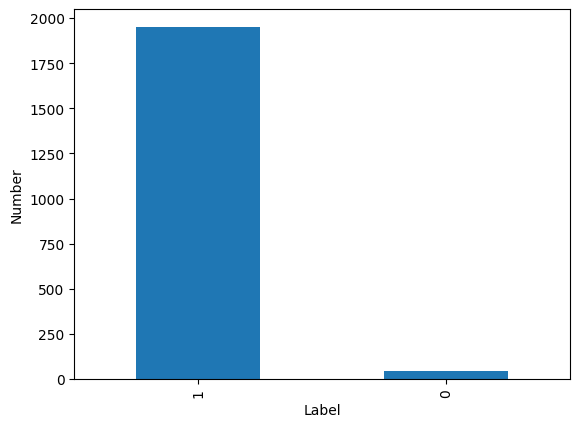

In [ ]:
dataset['sentiment'].value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

X_data와 y_data를 분리한 후 dataset 데이터프레임에서 입력 및 출력 데이터를 나타냅니다.

In [ ]:
# input / output 데이터 분리
X_data = dataset['contents']
y_data = dataset['sentiment']

print(type(X_data), type(y_data), len(X_data), len(y_data))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> 1997 1997


### [데이터 전처리 단계]

> 한국어 텍스트 데이터를 전처리하는 함수입니다. 전처리 과정으로는 한글 및 공백 제외한 문자 모두 제거, 형태소 단어로 나누기, 단어의 수를 계산하여 하나의 문자는 제거, 불용어 제거 등이 포함됩니다. 이 함수는 입력된 텍스트에 대해 전처리된 단어 리스트를 반환합니다.

In [ ]:
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
    # 1. 한글 및 공백 제외한 문자 모두 제거
    review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', review).replace('\n', '')

    #2. okt 객체를 활용하여 형태소 단어로 나눔
    word_review = okt.morphs(review_text, stem=True)

    #2.1 단어의 수를 계산하여 하나의 문자는 제거
    count = Counter(word_review)
    word_review = Counter({x : count[x] for x in count if len(x) > 1})

    if remove_stopwords:
        #3. 불용어 제거(선택 ==> default:False)
      word_review = [token for token in word_review if not token in stop_words]
    return word_review


> 해당 코드는 한국어 텍스트 데이터를 전처리하는 과정입니다.
1. 한글 및 공백 제외한 문자 모두 제거
2. okt 객체를 활용하여 형태소 단어로 나누기
3. 단어의 수를 계산하여 하나의 문자는 제거
4. 불용어 제거

>> 또한 전처리된 텍스트 데이터를 CountVectorizer를 활용하여 `DTM(Document Term Matrix)` 생성하는 과정을 보여줍니다. 마지막으로, 유사 단어 출현 횟수 데이터 프레임을 생성하고, 가장 출현 빈도수가 높은 단어들을 클라우드 형태로 보여주는 과정을 거칩니다.

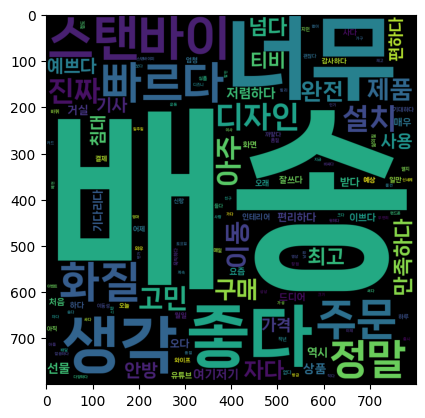

In [ ]:
okt = Okt()
# 전체 텍스트 전처리 (불용어 제거)
# 불용어 사전 불러오기
stop_dictionary = pd.read_csv('./drive/MyDrive/stopwords-ko.txt', names=['word'])
stop_words = list(np.array(stop_dictionary['word'].tolist()))
#stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한','님','다','셧','에']

#clean_X_data_review = X_data.apply(lambda x: preprocessing(str(x), okt, remove_stopwords=True, stop_words=STOP_WORDS) if type(x) == str else None)

clean_X_data_review = []

for review in X_data:
  # 리뷰가 문자열인 경우만 전처리 진행
  if type(review) == str:
    clean_X_data_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words = stop_words))
  else:
    clean_X_data_review.append([])

# empty input 제거
clean_X_data_review = [x for x in clean_X_data_review if x is not None]
y_data = y_data[:len(clean_X_data_review)]

# Flatten the two-dimensional array
clean_X_data_review_flattened = [doc[0] for doc in clean_X_data_review if len(doc) > 0]

# DTM (Document Term Matrix) 생성
tf_vectorizer = CountVectorizer()
tf_features = tf_vectorizer.fit_transform(clean_X_data_review_flattened)
tf = pd.DataFrame(tf_features.toarray(), columns=tf_vectorizer.get_feature_names_out())
features = np.array(tf_features.todense())

# 유사 단어 출현 횟수 데이터 프레임
c = Counter(clean_X_data_review_flattened)
wc = WordCloud(font_path='./drive/MyDrive/NanumSquareNeo-dEb.ttf', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(c)
plt.figure()
plt.imshow(gen)

### 훈련데이터, 테스트데이터 분리

- `TEST_SIZE`: 데이터 분리 비율 설정
- `RANDOM_STATE`: 난수 시드 설정
- `train_test_split()`: 학습 데이터와 테스트 데이터를 분리

In [ ]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42

# strtify = True 일 경우, 데이터 분리 이전의 라벨별 분포 고려
X_train, X_test, y_train, y_test = train_test_split(clean_X_data_review, y_data,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_data)

> 실제 데이터 비율 확인

In [ ]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 1597
테스트 입력 데이터 개수: 400


> 훈련 데이터 라벨별 비율, 테스트 데이터 라벨별 비율

In [ ]:
print (y_train.value_counts(normalize = True))
print (y_test.value_counts(normalize = True))

1    0.977458
0    0.022542
Name: sentiment, dtype: float64
1    0.9775
0    0.0225
Name: sentiment, dtype: float64


In [ ]:
"""
하이퍼파라미터 세팅
옵티마이저 Rectified Adam
"""
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
MIN_DELTA = 1e-3
PATIENCE = 5
EPOCHS = 100
BATCH_SZIE = 32
DROPOUT_RATE = 0.5
NUM_CLASS = 2
MAX_SEQ_LEN = 64

In [ ]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

### BERT 입력용 데이터 포맷으로 변경

> 한국어 텍스트 데이터를 BERT 입력 형식으로 변환하는 과정입니다. 입력 데이터(문장)의 길이가 최대 길이(MAX_SEQ_LEN)보다 길 경우, 문장이 잘려 입력됩니다. 문장 전후 관계를 구분하는 segment는 한 문장만 있는 경우 모두 0으로 초기화됩니다. 또한, 데이터를 학습과 테스트 데이터로 분리하고, 각각을 BERT 입력 형식으로 변환합니다.
- `MAX_SEQ_LEN`: 입력 데이터(문장)의 최대 길이
- `convert_data()`: BERT 입력으로 변환하는 함수
    - `tokenizer.encode()`: 입력 문장을 토큰화
    - `num_zeros`: 패딩이 아닌 토큰의 개수
    - `mask`: 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
    - `segment`: 문장 전후관계 구분
    - `tokens`, `masks`, `segments`, `targets`: BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트

In [ ]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

1597it [00:00, 9033.47it/s]
400it [00:00, 10744.23it/s]


- `train_x`, `train_y`: 학습 데이터를 BERT 입력 형식으로 변환한 결과
- `test_x`, `test_y`: 테스트 데이터를 BERT 입력 형식으로 변환한 결과

In [ ]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

> Hugging Face 라이브러리에서 제공하는 한국어 시퀀스 분류를 위한 BERT 모델을 사용하기 위한 입력값을 정의하는 코드입니다.
- `token_inputs` : 입력 텍스트의 단어들을 토큰화한 값입니다.
- `mask_inputs` : 입력 텍스트의 단어들을 마스킹한 값입니다.
- `segment_inputs` : 입력 텍스트가 하나의 문장인지, 두 개의 문장으로 구성된 것인지를 나타내는 값입니다.

>> 이렇게 정의된 입력값들은 `model`을 통해 BERT 모델에 입력으로 사용됩니다.

In [ ]:
bert_output = bert_outputs[0]

In [ ]:
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)

# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

> 해당 코드는 BERT 모델을 사용하여 한국어 시퀀스 분류를 수행하는 과정 중 하나인 출력층을 구성하는 과정입니다. 이전 코드에서 출력된 bert_output에 대해 `드롭아웃(Dropout)`을 수행하고, 이를 입력으로 받아 다중 클래스 분류를 수행하는 출력층을 생성합니다. 출력층의 활성화 함수는 softmax로 설정되며, NUM_CLASS는 분류해야 할 클래스 수를 의미합니다. 이렇게 생성된 출력층과 입력값들을 이용하여 sentiment_model을 정의합니다.

In [ ]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                         total_steps = TOTAL_STEPS,
                                         warmup_proportion = WARMUP_PROPORTION,
                                         min_lr = MIN_LR,
                                         epsilon = EPSILON,
                                         clipnorm = CLIPNORM)

> Rectified Adam 옵티마이저를 초기화합니다.
 Rectified Adam은 일반적인 Adam 옵티마이저를 개선한 것으로, 학습 속도를 높이고 더 나은 성능을 보이는 것으로 알려져 있습니다.
코드에서는 학습률, 총 스텝 수, 웜업 비율, 최소 학습률, 엡실론, 그리고 클립노름 등의 하이퍼파라미터를 설정하고, 이를 토대로 Rectified Adam 옵티마이저를 초기화합니다.

In [ ]:
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

> 감정분류 모델 컴파일

In [ ]:
early_stopping = EarlyStopping(monitor = "val_accuracy",
                              min_delta = MIN_DELTA,
                              patience = PATIENCE)

> EarlyStopping은 Keras에서 제공하는 콜백 중 하나로, 모델 학습 중 검증 데이터셋의 성능 지표에 대한 변화가 미미해지면 학습을 조기 종료시키는 기능을 수행합니다. monitor 인자에 모니터링할 지표를 지정하고, min_delta 인자에 어느 정도의 성능 변화를 무시할지를 지정하며, patience 인자에는 성능 지표가 개선되지 않은 상태를 얼마나 더 허용할지를 지정합니다.

In [ ]:
# Directory created.
def mkDirExistFolder (path_name):
  if path.exists(path_name) == False:
    os.mkdir(path_name)

  return path_name

In [ ]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = mkDirExistFolder('./sample_data/model/') + 'best_model.h5'

model_checkpoint = ModelCheckpoint(filepath = BEST_MODEL_NAME,
                                   monitor = "val_loss",
                                   mode = "min",
                                   save_best_only = True, # 성능 향상 시에만 모델 저장
                                   verbose = 1)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

### 감정 분류 모델 학습

> 트레인 데이터(train_x, train_y)를 사용하여 감성 분류 모델을 학습하고, 테스트 데이터(test_x, test_y)를 사용하여 검증하는 코드입니다. sentiment_model.fit() 메소드를 호출하여 모델을 학습하고, 검증 결과를 확인하며, 콜백 함수를 사용하여 모델의 성능을 모니터링합니다.

In [ ]:
sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5360
Epoch 1: val_loss improved from inf to 0.68989, saving model to ./sample_data/model/best_model.h5
50/50 [==============================] - 101s 919ms/step - loss: 0.6925 - accuracy: 0.5360 - val_loss: 0.6899 - val_accuracy: 0.9175
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.8384
Epoch 2: val_loss improved from 0.68989 to 0.67634, saving model to ./sample_data/model/best_model.h5
50/50 [==============================] - 37s 741ms/step - loss: 0.6846 - accuracy: 0.8384 - val_loss: 0.6763 - val_accuracy: 0.9775
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.9775
Epoch 3: val_loss improved from 0.67634 to 0.64500, saving model to ./sample_data/model/best_model.h5
50/50 [==============================] - 36s 724ms/step - loss: 0.6630 - accuracy: 0.9775 - val_loss: 0.6450 - val_accuracy: 0.9775
Epoch 4/100
50/5

In [ ]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [ ]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

13/13 [==============================] - 6s 143ms/step


> 분류된 데이터를 이용하여 Classification Report 파일을 생성합니다.

In [ ]:
# Classification Report 저장
CL_REPORT_FILE = "./sample_data/model/cl_report.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(2)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score  support
0                  0.00    0.00      0.00     9.00
1                  0.98    1.00      0.99   391.00
accuracy           0.98    0.98      0.98     0.98
macro avg          0.49    0.50      0.49   400.00
weighted avg       0.96    0.98      0.97   400.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> 테스트 데이터와 예측 결과를 바탕으로 혼동 행렬을 생성하고, 이를 시각화하여 출력합니다.

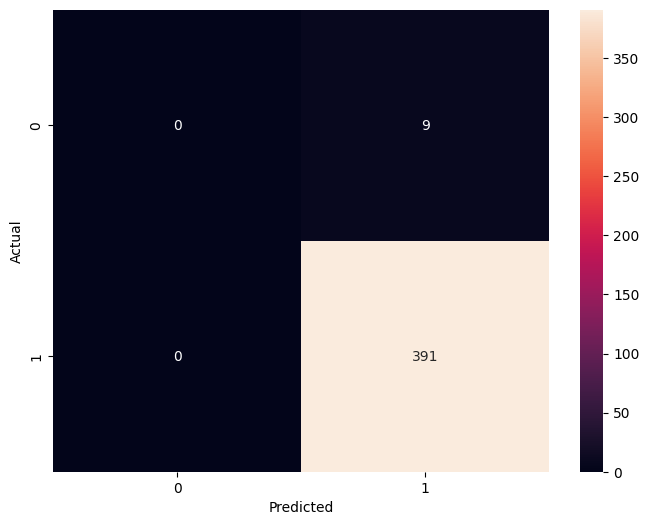

In [ ]:
# 이미지 파일 저장정보
FIGURE_FILE = mkDirExistFolder('./sample_data/figure/') + "cf_matrix.png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(FIGURE_FILE)
plt.show()

> Multi-class Classification에서 사용되는 대중적인 평가 지표들을 계산하는 코드입니다. 코드에서 각각의 평가 지표들을 계산하기 위해 scikit-learn 라이브러리의 함수들을 사용합니다.
- accuracy_score: 정확도
- precision_score: 정밀도
- recall_score: 재현율
- f1_score: F1 점수
- roc_auc_score: ROC AUC 점수
- cohen_kappa_score: Cohen's Kappa 점수
- matthews_corrcoef: Matthews Correlation Coefficient
- log_loss: 로그 손실
각 지표들은 다양한 측면에서 모델의 성능을 평가하는 데 사용됩니다.

In [ ]:
# Multi-class Classification의 대중적인 평가 지표 모두 확인

accuracy_score_v = round(accuracy_score(y_test, predicted_label), 2) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 2) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 2) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 2) # F1 Score
#roc_auc_score_v = round(roc_auc_score(y_test, predicted_value, average="weighted", multi_class="ovr"), 2) # ROC AUC Score
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 2) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 2) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(y_test, predicted_value), 2) # Log Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> 평가 지표를 확인할 수 있도록 csv 형태의 파일로 저장합니다.

In [ ]:
METRIC_FILE = mkDirExistFolder('./sample_data/metric/') + 'metric.csv'
metric_total = pd.DataFrame({'PLM' : MODEL_NAME,
                             'Optimizer' : OPTIMIZER_NAME,
                             'Accuracy' : accuracy_score_v,
                             'Precision' : precision_score_v,
                             'Recall' : recall_score_v,
                             'F1_score' : f1_score_v,
                             #'ROC_AUC_score' : roc_auc_score_v,
                             'Cohen_kappa_coef' : cohen_kappa_score_v,
                             'Matthews_corrcoef' : matthews_corrcoef_v,
                             'Log_loss' : log_loss_v},
                             index = ['-'])

In [ ]:
metric_total.to_csv(METRIC_FILE)
print(metric_total)

              PLM Optimizer  Accuracy  Precision  Recall  F1_score  \
-  klue/bert-base     RAdam      0.98       0.96    0.98      0.97   

   Cohen_kappa_coef  Matthews_corrcoef  Log_loss  
-               0.0                0.0      0.55  
